# We compute the $H^{-1}$ norm via the Green's function

We need to solve the problem 
$$
-\Delta_x G(x-y) = \delta (y-x) \\
G(x,y) = 0 
$$

Note that if 
$$
-\Delta \varphi_n(x) = \lambda_n \varphi(x)
$$

Then 
$$
G(x,y) = \sum_{i=1}^\infty \frac{1}{\lambda_n}\varphi_n(x)\varphi_n(y)
$$

Consider the 1D Poisson equation with zero boundary condition:
$$
-\Delta u = f \quad \text{in} \quad(0, L) \\
u(x) = 0 \quad \text{for} \quad x = 0, L
$$
We have
$$
-\Delta  \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) =  \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = \lambda_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

And therefore
$$
G(x,y) = \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) \sin\Big(\frac{n\pi y}{L}\Big) 
$$


We aim to compute 
$$
A_{i,j} = \int_{\Omega} \psi_i \Delta^{-1} \psi_j
$$
for $\psi_j$ being measurement function. By the above 
$$
\Delta^{-1} \psi = \int G(x,y)\psi(y)dy =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) \int \sin\Big(\frac{n\pi y}{L}\Big)  \psi(y)dy
$$

Hence 
$$
\Delta^{-1} \psi_i(x) =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n \sin\Big(\frac{n\pi x}{L}\Big)
$$

and 
$$
A_{i,j} = \int_{\Omega} \psi_i(x) \Delta^{-1} \psi_j(x) =   \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n \int \sin\Big(\frac{n\pi x}{L}\Big)\psi_i(x) dx =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n c^j_n
$$

Hence the algorith is 

\begin{aligned}
&\text{Compute }  c^l_n =  \int \sin\Big(\frac{n\pi y}{L}\Big)  \psi_l(y)dy \quad \text{ for each $1\leq l \leq K$ and $1 \leq n \leq  N$} \\
&\text{Build } A_{i,j} =  \sum_{n=1}^\infty  \frac{ L^2}{ n^2\pi^2}\sqrt{\frac{2}{L}} c^i_n c^j_n
\end{aligned}

In [25]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import numpy as np

import matplotlib.pyplot as plt


from jax.config import config
config.update("jax_enable_x64", True)

from jax import lax, vmap, jit

from pdb import set_trace as bp

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_29716\93601395.py:10: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


# Generating an example


Let us solve 
\begin{aligned}
 -\varepsilon \Delta u -u &= f \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
f =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\varepsilon\frac{n^2\pi^2}{L^2} - 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

In [26]:
def evaluate_function(x, coef, L):
    values = 0
    for i, c in enumerate(coef):
        values +=c*jnp.sin((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
    return values

5.25


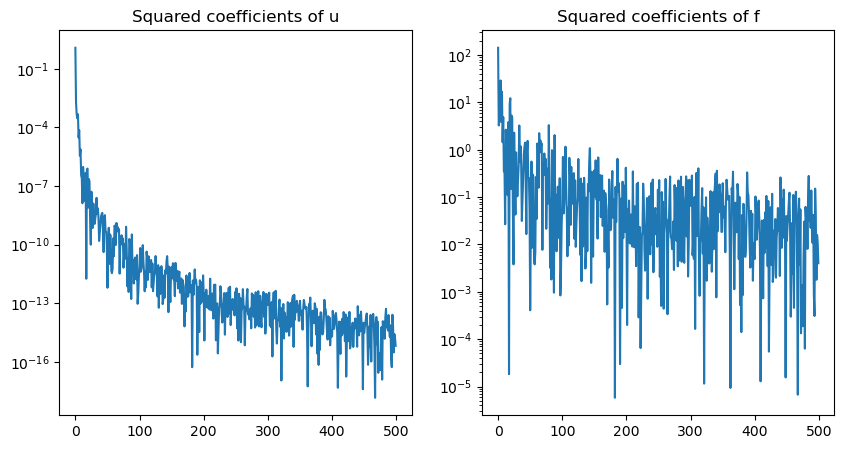

Text(0.5, 1.0, 'Function f')

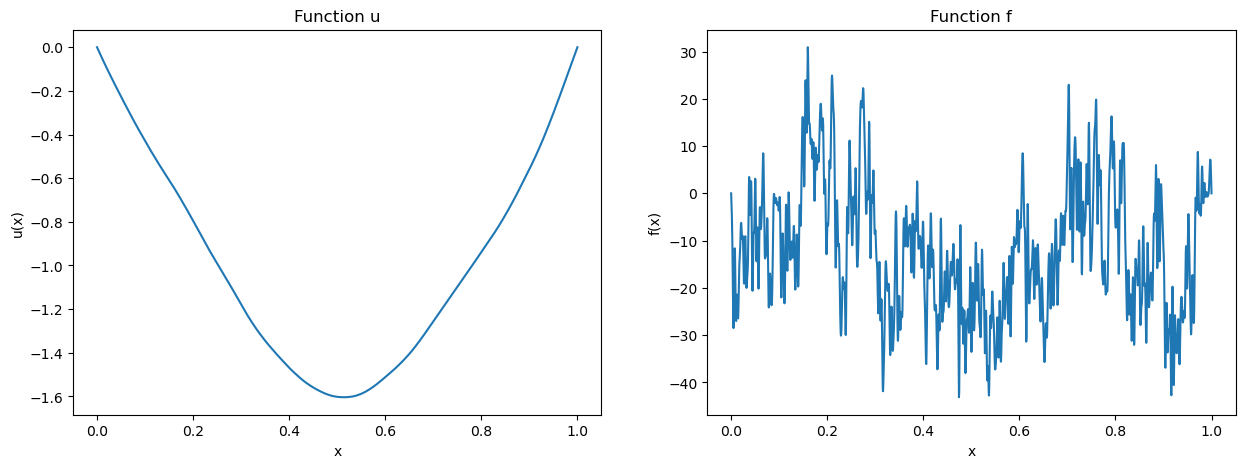

In [27]:
# Create the RHS

epsilon = 1.0

# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 2
alpha = 2*s+1 + 0.25
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f = coef_u*(epsilon*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2 -1)

x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L)

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

## Create measurements of the RHS

In [28]:
from scipy.special import roots_legendre
from utils_rough_pde import vmap_root_interval, indicator_vector

In [29]:
lower, upper = 0.0, 1.0

boundary = jnp.array([[lower, upper]]).T
L =upper -lower 

# Construct the measurements
n_meas = 200
epsilon_values =  jnp.array([L/(n_meas*2)])
loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

In [30]:
from scipy.special import roots_legendre
n_order = 20
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

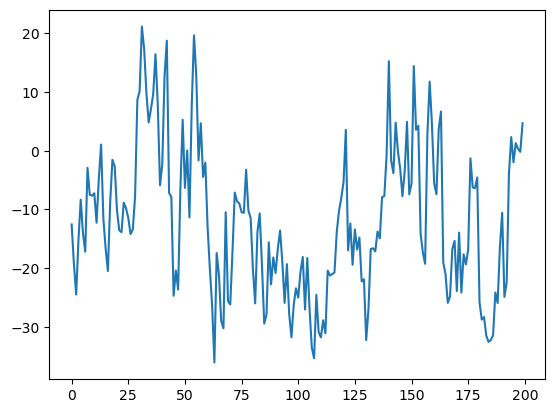

In [31]:
from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi

# Compute the RHS of the linear system
f_quad = evaluate_function(root_psi, coef_f, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

plt.plot(f_meas)

## Intermediate step: solving elliptic equations

Let us solve 
\begin{aligned}
 -\varepsilon \Delta u -u &= f \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}


We will define $L$ to be a diff operator taking $K$ and returning 

\begin{aligned}
&L_x K(x,y) \\
&L_y L_x K(x,y)
\end{aligned}

In this case:
$$
L_x = -\varepsilon\Delta_x - I
$$
so 
$$
L_y L_x = (-\varepsilon\Delta_y - I)(-\varepsilon\Delta_x - I) = \varepsilon^2\Delta_y \Delta_x  + \varepsilon\Delta_y + \varepsilon\Delta_x + I
$$

We need to form the matrix 

$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) & \int L_y K(X_{\partial\Omega}, y)\psi \\
\int L_y K(X_{\partial\Omega}, y)\psi ^\intercal & \int \int  L_y L_x K( x, y) \psi(x)\psi(y)
\end{bmatrix}
$$

We will use the approximation
\begin{aligned}
&\int L_y K(X_{\partial\Omega}, y)\psi \approx \sum_{i}^{N_q}  w_i L_y K(X_{\partial\Omega}, y_i) \psi(y_i) \\
& \int \int  L_y L_x K( x, y) \psi(x)\psi(y) = \sum_{i}^{N_q} \sum_{j}^{N_q} w_i w_j \psi(x_i) L_y L_x K(x_i, y_j) \psi(y_j)
\end{aligned}

To evaluate, we have to compute 
$$
\begin{bmatrix}
K(X,X_{\partial\Omega}) & \int L_y K(X, y)\psi
\end{bmatrix} \alpha
$$

In [32]:
from utils_elliptic import theta_blocks

length_scale = 1.0
theta_11, theta_21, theta_22 = theta_blocks(boundary,psi_matrix, root_psi, length_scale, epsilon)
theta_12 = theta_21.T

In [33]:
theta_11.shape, theta_21.shape, theta_12.shape,  theta_22.shape

((2, 2), (200, 2), (2, 200), (200, 200))

# Creating the stiffness matrix 

In [34]:
from utils_rough_pde import indicator
vmap_indicator_proj = vmap(indicator, in_axes=(0, None, 0))

def compute_projection_sin(x_q, w_q, f_values, n_coef, L):
    sin_basis = jnp.sqrt(2/L)*jnp.array([jnp.sin(jnp.pi*k/L*x_q) for k in range(1, n_coef+1)])
    return jnp.sum(f_values[None]*sin_basis*w_q, axis = -1)

vmap_compute_projection_sin = vmap(compute_projection_sin, in_axes=(0, 0, 0, None, None))

def build_A(c_1, c_2, L):
    n_coef = c_1.shape[0]
    weights = jnp.arange(n_coef) +1
    weights = weights*jnp.pi/L
    weights = weights**(-2)*jnp.sqrt(2/L)
    return jnp.sum(weights*c_1*c_2)


vmap_A = vmap(vmap(build_A, in_axes=(0, None, None)), in_axes=(None, 0, None))

In [35]:
bump_proj = vmap_indicator_proj(x_interval, epsilon_values, loc_values)
proj_indicator = vmap_compute_projection_sin(x_interval, w_interval, bump_proj, n_coef, L)

A  = vmap_A(proj_indicator, proj_indicator, L)
A.shape

(200, 200)

# Solving the optimization problem

\begin{aligned}
\min_{\alpha} \quad &\alpha^\intercal \Big(K(\phi, \chi) A K(\chi, \phi)  + \lambda  \Theta \Big)\alpha - 2[f, \psi]AK( \chi, \phi)\alpha\\
& K(X_{\partial\Omega}, \phi)\alpha = 0
\end{aligned}

In [36]:
nugget = 1e-5
nugget_stability = 1e-10

In [37]:
theta = jnp.block([[theta_11, theta_12], [theta_21, theta_22]])

In [38]:
theta = jnp.block([[theta_11, theta_12], [theta_21, theta_22]])
Q_constraint = jnp.hstack([theta_11, theta_12])
K_interior = jnp.vstack([theta_12, theta_22])
q = -K_interior@A@f_meas
P = K_interior@A@K_interior.T + nugget*theta + nugget_stability*jnp.eye(theta.shape[0])
eigvals, eigvecs = scipy.linalg.eigh(P)
print(jnp.min(eigvals))

bc = jnp.zeros(shape = (2, ))

Q_constraint.shape, q.shape, P.shape

3.5136477589912127e-06


((2, 202), (202,), (202, 202))

In [39]:
Q_constraint.shape, q.shape, P.shape

((2, 202), (202,), (202, 202))

In [40]:
from jaxopt import EqualityConstrainedQP

In [41]:
qp = EqualityConstrainedQP(tol=1e-5, refine_regularization=1.0, refine_maxiter=300)
#qp = EqualityConstrainedQP(tol=1e-5)

sol = qp.run(params_obj=(P, q), params_eq=(Q_constraint, bc))
alpha_opt = sol.params.primal

In [42]:
Q_constraint@alpha_opt,  bc

(Array([ 3.48903393e-06, -3.12612231e-06], dtype=float64),
 Array([0., 0.], dtype=float64))

In [43]:
from utils_elliptic import *

In [44]:
@jit
def evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary, epsilon):
    K_boundary = vmap_kernel(x,boundary, length_scale)
    K_interior = jnp.squeeze(vmap_linear_form_K(psi_matrix, x[:, None], root_psi, length_scale, epsilon), axis = -1).T
    K_evaluate = jnp.block([[K_boundary, K_interior]])

    return K_evaluate@c

In [45]:
pred = evaluate_prediction(x, alpha_opt, length_scale, root_psi, psi_matrix, boundary, epsilon)

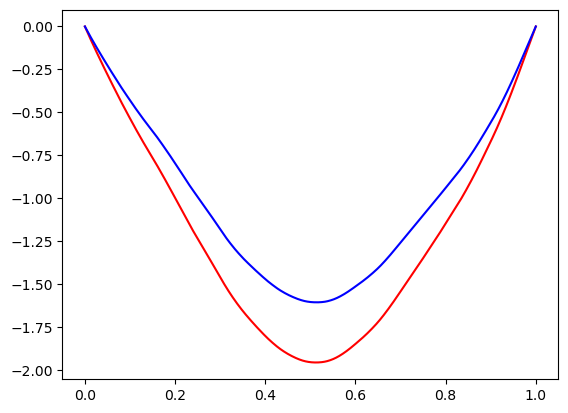

In [46]:
plt.plot(x, pred, color = "red")
plt.plot(x, u_values, color = "blue")

In [49]:
theta_12

Array([[ 0.66657022,  0.66599765,  0.6648692 ,  0.66320271,  0.66101561,
         0.65832499,  0.65514753,  0.65149956,  0.64739705,  0.64285562,
         0.63789052,  0.63251668,  0.6267487 ,  0.62060084,  0.61408704,
         0.60722091,  0.60001579,  0.59248466,  0.58464026,  0.57649498,
         0.56806097,  0.55935007,  0.55037385,  0.54114362,  0.53167039,
         0.52196495,  0.51203781,  0.50189923,  0.49155923,  0.48102759,
         0.47031383,  0.45942726,  0.44837697,  0.4371718 ,  0.42582038,
         0.41433113,  0.40271226,  0.39097176,  0.37911744,  0.36715688,
         0.35509749,  0.34294649,  0.33071088,  0.31839753,  0.30601307,
         0.29356401,  0.28105664,  0.2684971 ,  0.25589138,  0.24324528,
         0.23056446,  0.21785441,  0.20512048,  0.19236785,  0.17960158,
         0.16682657,  0.15404757,  0.14126922,  0.128496  ,  0.11573226,
         0.10298223,  0.09025002,  0.07753959,  0.0648548 ,  0.05219939,
         0.03957696,  0.02699104,  0.014445  ,  0.0

In [48]:
theta_11

Array([[1.        , 0.52399411],
       [0.52399411, 1.        ]], dtype=float64)